In [1]:
%run imports.ipynb

2016-10-14 22:17:01.879597


In [2]:
%run db.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MySQL database already running...


2016-10-14 22:17:02.120055


In [273]:
NOTEBOOK_NAME = 'validation_cancer'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [19]:
train_uniprot_ids = set()

# Prepare

In [588]:
1 is 1

True

In [590]:
10000 is 10000

True

In [595]:
x = 1000
y = 1000
x is y

False

In [27]:
if CORE_OR_INTERFACE in [0, 'core']:
    TRAINING_DATASET_NAME = 'protherm++'
    COI_SUFFIX = '_CORE'
    CORE_DATA = pd.read_pickle('load_data/DATA_DF_CORE.pkl')

if CORE_OR_INTERFACE in [1, 'interface']:
    TRAINING_DATASET_NAME = 'skempi++'
    COI_SUFFIX = '_INTERFACE'

In [28]:
with open('machine_learning/clf_features{}.json'.format(COI_SUFFIX), 'r') as ifh:
    clf_features = json.load(ifh)

In [29]:
with open('machine_learning/clf_options{}.json'.format(COI_SUFFIX), 'r') as ifh:
    clf_options = json.load(ifh)

In [30]:
with open('machine_learning/clf{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
    clf = pickle.load(ifh)

In [31]:
if CORE_OR_INTERFACE in [0, 'core']:
    with open('machine_learning/TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
        DATA_DF_CORE = pickle.load(ifh)
        train_uniprot_ids.update(set(DATA_DF_CORE[TRAINING_DATASET_NAME]['uniprot_id']))
    COSMIC_CORE = CORE_DATA[CORE_DATA['dataset'] == 'cosmic']
    _before = COSMIC_CORE.shape[0]
    COSMIC_CORE = COSMIC_CORE.dropna(subset=clf_features)
    print("Lost {} rows due to null features...".format(_before - COSMIC_CORE.shape[0]))
    COSMIC_CORE['ddg_pred_core'] = clf.predict(COSMIC_CORE[clf_features])
    COSMIC_CORE['dg_change_core'] = COSMIC_CORE['dg_change']

if CORE_OR_INTERFACE in [1, 'interface']:
    with open('machine_learning/TRAINING_SETS_NONULL{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
        DATA_DF_INTERFACE = pickle.load(ifh)
        train_uniprot_ids.update(set(DATA_DF_INTERFACE[TRAINING_DATASET_NAME]['uniprot_id']))
    print(DATA_DF_INTERFACE.keys())
    COSMIC_INTERFACE = (
        pd.concat(
            [DATA_DF_INTERFACE['cosmic_train'], DATA_DF_INTERFACE['cosmic_test']],
            ignore_index=True
        ))
    COSMIC_INTERFACE['dg_change_interface'] = COSMIC_INTERFACE['dg_change']
    COSMIC_INTERFACE['ddg_pred_interface'] = clf.predict(COSMIC_INTERFACE[clf_features])
    COSMIC_INTERFACE = (
        COSMIC_INTERFACE
        [['uniprot_id', 'uniprot_mutation', 'dg_change_interface', 'ddg_pred_interface']]
        .groupby(['uniprot_id', 'uniprot_mutation'], as_index=False)
        .mean()
    )

odict_keys(['skempi++', 'taipale_train', 'taipale_ppi_train', 'taipale_gpca_train', 'humsavar_train', 'clinvar_train', 'cosmic_train', 'humsavar_test', 'clinvar_test', 'cosmic_test', 'cagi4_sumo_ligase', 'ab_bind', 'hiv_escape_mutations', 'benedix_et_al'])


After both core and interface were run...

In [34]:
COSMIC = (
    COSMIC_CORE
    .merge(
        COSMIC_INTERFACE,
        on=['uniprot_id', 'uniprot_mutation'],
        how='left'
    )
)

In [35]:
assert (COSMIC['ddg_pred_interface'].dropna().shape[0] - COSMIC_INTERFACE.shape[0]) < 1000

In [36]:
COSMIC['ddg_pred'] = (
    COSMIC['ddg_pred_core'] + 
    (COSMIC['ddg_pred_interface'] - COSMIC['ddg_pred_interface'].mean()).fillna(0)
)

COSMIC['dg_change'] = (
    COSMIC['dg_change_core'] + 
    (COSMIC['dg_change_interface'] - COSMIC['dg_change_interface'].mean()).fillna(0)
)

In [37]:
COSMIC[['dg_change', 'dg_change_core', 'dg_change_interface']].head()

,dg_change,dg_change_core,dg_change_interface
0,0.157,0.157,NaN
1,0.074,0.074,NaN
2,-0.943,-0.943,NaN
3,-0.618,-0.618,NaN
4,3.467,3.467,NaN


In [38]:
COSMIC.shape[0]

357703

In [142]:
len(train_uniprot_ids)

217

In [149]:
len(train_gene_names)

186

In [144]:
sql_query = """\
SELECT DISTINCT uniprot_id, gene_name
FROM uniprot_kb.uniprot_sequence
WHERE uniprot_id IN ('{}')
""".format("', '".join([u for u in train_uniprot_ids if pd.notnull(u)]))

In [145]:
uniprot_training_set = pd.read_sql_query(sql_query, db_remote.engine)

In [146]:
train_gene_names = set(uniprot_training_set['gene_name'])

In [148]:
train_gene_names |= {'NOTCH1', 'NPM1', 'CEBPA'}

# Run mutations

Do this only once!

In [9]:
# Before making sure that you have all models (i.e. RUN_TYPE = 1 / 2)
sql_query = """
SELECT distinct uniprot_id, uniprot_mutation
FROM intogen.uniprot_to_ensembl
JOIN elaspic.uniprot_domain USING (uniprot_id)
JOIN elaspic.uniprot_domain_template USING (uniprot_domain_id)
WHERE elaspic.MUTATION_IN_DOMAIN(uniprot_mutation, domain_def)
AND (uniprot_id, uniprot_mutation) NOT IN (
    SELECT uniprot_id, uniprot_mutation 
    FROM elaspic.uniprot_domain_mutation
    WHERE ddg is not NULL
);"""

In [213]:
# After making sure that you have all models (i.e. RUN_TYPE = 3)
sql_query = """
SELECT distinct uniprot_id, uniprot_mutation
FROM intogen.uniprot_to_ensembl
JOIN elaspic.uniprot_domain USING (uniprot_id)
JOIN elaspic.uniprot_domain_template USING (uniprot_domain_id)
WHERE elaspic.MUTATION_IN_DOMAIN(uniprot_mutation, domain_def)
AND (uniprot_id, uniprot_mutation) NOT IN (
    SELECT uniprot_id, uniprot_mutation 
    FROM elaspic.uniprot_domain_mutation
    WHERE ddg is not NULL
);"""

In [214]:
mutations_wtemplates = pd.read_sql_query(sql_query, db_remote.engine)

In [215]:
mutations_wtemplates.shape

(5612, 2)

In [216]:
mutations_wtemplates_bak = mutations_wtemplates.copy()

## qsub

In [217]:
RUN_NUMBER = 3  # 1: Provean and domain models, 2: Interface models, 3: Mutations
print(RUN_NUMBER)

mutations_wtemplates = mutations_wtemplates_bak.copy()

if RUN_NUMBER == 1:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/strokach/databases/blast/db' \
        --blast_db_dir='/home/kimlab1/database_data/blast/db' \
        --archive_dir='/home/kimlab1/database_data/elaspic_v2' \
        --connection_string='{connection_string}' \
        -vvv \
        -t sequence \
        -u '{uniprot_id}' \
        # {uniprot_mutation}
    """
    mutations_wtemplates = mutations_wtemplates.drop_duplicates('uniprot_id')

elif RUN_NUMBER == 2:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/kimlab1/database_data/blast/db' \
        --archive_dir='/home/kimlab1/database_data/elaspic_v2' \
        --connection_string='{connection_string}' \
        -vvv \
        -t model \
        -u '{uniprot_id}' \
        # {uniprot_mutation}
    """
    mutations_wtemplates = mutations_wtemplates.drop_duplicates('uniprot_id')

elif RUN_NUMBER == 3:
    system_command_template = """\
    elaspic run \
        --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/' \
        --blast_db_dir='/home/kimlab1/database_data/blast/db' \
        --archive_dir='/home/kimlab1/database_data/elaspic_v2' \
        --connection_string='{connection_string}' \
        -vvv \
        -t mutation \
        -u '{uniprot_id}' \
        -m '{uniprot_mutation}'
    """

3


In [218]:
SUFFIX = '_1_{}'.format(RUN_NUMBER)
JOB_NAME = 'intogen_mutations{}'.format(SUFFIX)

mutations_wtemplates['system_command'] = [
    system_command_template
    .format(
        connection_string=db_remote.connection_string + '/elaspic',
        uniprot_id=uniprot_id,
        uniprot_mutation=uniprot_mutation
    )
    for uniprot_id, uniprot_mutation
    in mutations_wtemplates[['uniprot_id', 'uniprot_mutation']].values
]

In [219]:
mutations_wtemplates.head()

,uniprot_id,uniprot_mutation,system_command
0,Q96RU2,A598S,elaspic run --pdb_dir='/home/kimla...
1,Q96RU2,D255N,elaspic run --pdb_dir='/home/kimla...
2,Q96RU2,E371Q,elaspic run --pdb_dir='/home/kimla...
3,Q96RU2,F365S,elaspic run --pdb_dir='/home/kimla...
4,Q96RU2,G304E,elaspic run --pdb_dir='/home/kimla...


In [220]:
!echo {mutations_wtemplates['system_command'][0]}

elaspic run --pdb_dir=/home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/ --blast_db_dir=/home/kimlab1/database_data/blast/db --archive_dir=/home/kimlab1/database_data/elaspic_v2 --connection_string=mysql://strokach:@192.168.6.19:3306/elaspic -vvv -t mutation -u Q96RU2 -m A598S


In [221]:
!{mutations_wtemplates['system_command'][0]}

Creating 'unique_temp_dir' folder: /tmp/strokach/elaspic/gz2vgdxk...
Creating 'pdb_dir' folder: /home/kimlab1/database_data/pdb/data/data/structures/divided/pdb/...
Creating 'temp_dir' folder: /tmp/strokach/elaspic...
Creating 'tcoffee_dir' folder: /tmp/strokach/elaspic/gz2vgdxk/model/tcoffee...
Creating 'archive_temp_dir' folder: /tmp/strokach/elaspic/archive...
Creating 'data_dir' folder: /home/kimlab1/strokach/working/elaspic/elaspic/data...
Creating 'modeller_dir' folder: /tmp/strokach/elaspic/gz2vgdxk/model/modeller...
Creating 'archive_dir' folder: /home/kimlab1/database_data/elaspic_v2...
Creating 'provean_temp_dir' folder: /tmp/strokach/elaspic/gz2vgdxk/sequence/provean_temp...
Creating 'blast_db_dir' folder: /home/kimlab1/database_data/blast/db...
Creating 'sequence_dir' folder: /tmp/strokach/elaspic/gz2vgdxk/sequence...
Creating 'model_dir' folder: /tmp/strokach/elaspic/gz2vgdxk/model...


8888888888 888             d8888  .d8888b.  8888888b. 8888888 .d8888b.
888        888  

In [222]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

js = jobsubmitter.JobSubmitter(
    JOB_NAME, 'sge://:@192.168.6.201', op.abspath(NOTEBOOK_NAME),
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='2:00:00', mem='4G',
    env={'PATH': PATH},
)

In [223]:
logging.getLogger('jobsubmitter').setLevel(logging.WARNING)

In [224]:
with js.connect():
    js.submit(mutations_wtemplates.reset_index()[['index', 'system_command']].values.tolist())

In [225]:
with js.connect():
    print(js.get_num_running_jobs())

28


### Read results

In [81]:
# Get job status
results_df = (
    js.job_status(mutations_wtemplates.reset_index()[['index', 'system_command']].values.tolist()))
print(Counter(results_df['status']))

Counter({'misformed output': 241, 'frozen': 10, 'error': 6})


In [37]:
results_df.head()

,job_id,status,system_command
0,0,frozen,elaspic run --pdb_dir='/home/kimla...
1,18,misformed output,elaspic run --pdb_dir='/home/kimla...
2,22,misformed output,elaspic run --pdb_dir='/home/kimla...
3,57,misformed output,elaspic run --pdb_dir='/home/kimla...
4,69,misformed output,elaspic run --pdb_dir='/home/kimla...


In [38]:
# Job statistics
failed = set(results_df[~results_df['status'].isin(['misformed output'])]['job_id'])

system_commands_remaining = (
    mutations_wtemplates[
        (mutations_wtemplates.index.isin(failed))
    ]
)
print(len(system_commands_remaining))

20


In [39]:
system_commands_remaining[:10]

,uniprot_id,uniprot_mutation,system_command
0,Q96RU2,A598S,elaspic run --pdb_dir='/home/kimla...
571,P51946,D192N,elaspic run --pdb_dir='/home/kimla...
1069,P25940,A1096T,elaspic run --pdb_dir='/home/kimla...
1782,Q92616,A1421T,elaspic run --pdb_dir='/home/kimla...
1874,Q15393,A122V,elaspic run --pdb_dir='/home/kimla...
1999,Q15653,A265V,elaspic run --pdb_dir='/home/kimla...
2120,Q14683,A178V,elaspic run --pdb_dir='/home/kimla...
2532,P20231,A239V,elaspic run --pdb_dir='/home/kimla...
2846,Q9NTJ3,D150N,elaspic run --pdb_dir='/home/kimla...
3132,Q9UQE7,A163G,elaspic run --pdb_dir='/home/kimla...


In [40]:
with js.connect():
    js.submit(system_commands_remaining.reset_index()[['index', 'system_command']].values.tolist())

# Process data 

Do this only once!

In [461]:
if CORE_OR_INTERFACE in [0, 'core']:
    sql_query = """\
    SELECT 
    gdna, gene, ensembl_id, ensembl_mutation,
    known_oncogenic, known_predisposing, cadd_phred, driver_gene, gene_role, driver_mut_prediction, cancer, 
    alt_type, driver,
    t.*
    FROM intogen.intogen_driver_mutations_catalog
    JOIN intogen.uniprot_to_ensembl USING (ensembl_id, ensembl_mutation)
    JOIN (
        SELECT *, mutation uniprot_mutation
        FROM elaspic.uniprot_domain_template
        JOIN elaspic.uniprot_domain_model USING (uniprot_domain_id)
        JOIN elaspic.uniprot_domain_mutation USING (uniprot_domain_id)
    ) t USING (uniprot_id, uniprot_mutation);
    """

In [462]:
if CORE_OR_INTERFACE in [1, 'interface']:
    sql_query = """\
    SELECT 
    gdna, gene, ensembl_id, ensembl_mutation,
    known_oncogenic, known_predisposing, cadd_phred, driver_gene, gene_role, driver_mut_prediction, cancer, 
    alt_type, driver,
    t.*
    FROM intogen.intogen_driver_mutations_catalog
    JOIN intogen.uniprot_to_ensembl USING (ensembl_id, ensembl_mutation)
    JOIN (
        SELECT *, mutation uniprot_mutation
        FROM elaspic.uniprot_domain_pair
        JOIN elaspic.uniprot_domain_pair_template USING (uniprot_domain_pair_id)
        JOIN elaspic.uniprot_domain_pair_model USING (uniprot_domain_pair_id)
        JOIN elaspic.uniprot_domain_pair_mutation USING (uniprot_domain_pair_id)
        WHERE (uniprot_id_1 not like '%%-%%' AND uniprot_id_2 not like '%%-%%')
    ) t USING (uniprot_id, uniprot_mutation);
    """

In [477]:
print(sql_query)

    SELECT 
    gdna, gene, ensembl_id, ensembl_mutation,
    known_oncogenic, known_predisposing, cadd_phred, driver_gene, gene_role, driver_mut_prediction, cancer, 
    alt_type, driver,
    t.*
    FROM intogen.intogen_driver_mutations_catalog
    JOIN intogen.uniprot_to_ensembl USING (ensembl_id, ensembl_mutation)
    JOIN (
        SELECT *, mutation uniprot_mutation
        FROM elaspic.uniprot_domain_pair
        JOIN elaspic.uniprot_domain_pair_template USING (uniprot_domain_pair_id)
        JOIN elaspic.uniprot_domain_pair_model USING (uniprot_domain_pair_id)
        JOIN elaspic.uniprot_domain_pair_mutation USING (uniprot_domain_pair_id)
        WHERE (uniprot_id_1 not like '%%-%%' AND uniprot_id_2 not like '%%-%%')
    ) t USING (uniprot_id, uniprot_mutation);
    


In [463]:
intogen = pd.read_sql_query(sql_query, db_remote.engine)

In [464]:
intogen = elaspic.elaspic_predictor.format_mutation_features(intogen)
intogen = elaspic.elaspic_predictor.convert_features_to_differences(intogen)

In [479]:
clf_features

['solvation_polar_wt',
 'cis_bond_wt',
 'backbone_clash_wt',
 'electrostatic_kon_wt',
 'partial_covalent_bonds_wt',
 'energy_ionisation_wt',
 'intraclashes_energy_2_change',
 'backbone_hbond_change',
 'solvation_polar_change',
 'solvation_hydrophobic_change',
 'entropy_sidechain_change',
 'sloop_entropy_change',
 'torsional_clash_change',
 'backbone_clash_change',
 'water_bridge_change',
 'entropy_complex_change',
 'pcv_salt_equal_wt',
 'pcv_hbond_wt',
 'pcv_vdw_wt',
 'pcv_salt_opposite_self_wt',
 'pcv_vdw_self_wt',
 'pcv_salt_opposite_change',
 'pcv_salt_equal_self_change',
 'pcv_salt_opposite_self_change',
 'pcv_hbond_self_change',
 'pcv_vdw_self_change',
 'provean_score',
 'alignment_score']

In [488]:
if 'alignment_score' not in intogen:
    intogen['alignment_score'] = np.sqrt(intogen['score_1'] * intogen['score_2'])
assert ((intogen['alignment_score'] > 0.001) & (intogen['alignment_score'] <= 1)).all()

In [489]:
if 'ddg_pred' not in intogen:
    _before = intogen.shape[0]
    intogen = intogen.dropna(subset=clf_features)
    print("Lost {} rows due to missing features.".format(_before - intogen.shape[0]))
    intogen['ddg_pred'] = clf.predict(intogen[clf_features])

Lost 44 rows due to missing features.


In [490]:
if CORE_OR_INTERFACE in [0, 'core']:
    intogen_unique = intogen.drop_duplicates(subset=['uniprot_id', 'uniprot_mutation'])

In [160]:
if CORE_OR_INTERFACE in [1, 'interface']:
    columns = [
        'uniprot_id', 'uniprot_mutation',
        'gdna', 'gene', 'ensembl_id', 'ensembl_mutation',
        'known_oncogenic',
        'known_predisposing', 'driver_gene', 'gene_role', 
        'driver_mut_prediction', 'cancer', 'alt_type', 'driver',
    ]

    intogen.loc[:, columns] = intogen.loc[:, columns].fillna('')
    intogen_unique = intogen.groupby(columns, as_index=False).mean()

    intogen.loc[:, columns] = intogen[columns].replace('', np.nan)
    intogen_unique.loc[:, columns] = intogen_unique[columns].replace('', np.nan)

### Save cache

In [161]:
kmtools.df_tools.dump_csv(intogen, op.join(NOTEBOOK_NAME, 'intogen{}.tsv.gz'.format(COI_SUFFIX)))

In [162]:
kmtools.df_tools.dump_csv(intogen_unique, op.join(NOTEBOOK_NAME, 'intogen_unique{}.tsv.gz'.format(COI_SUFFIX)))

# Load data 

## uniprot_gene_name

In [54]:
sql_query = """\
SELECT uniprot_acc uniprot_id, identifier_id gene_name
FROM uniprot_kb_proteomes.UP000005640_9606_idmapping where identifier_type = 'Gene_Name';
"""

In [55]:
uniprot_gene_name = pd.read_sql_query(sql_query, db_remote.engine)

In [56]:
uniprot_gene_name.head(2)

,uniprot_id,gene_name
0,M0R009,A1BG
1,P04217,A1BG


## cancer_gene_census

In [57]:
!ls $NOTEBOOK_NAME

Census_allThu Oct 13 19-43-09 2016.csv	intogen.tsv.gz
df.pkl					intogen.tsv.gz.dtype
df_unique.pkl				intogen_unique.csv
intogen.csv.dtypes			intogen_unique.csv.bz2
intogen.csv.gz				intogen_unique.csv.gz
intogen.csv.gz.dshape			intogen_unique.csv.gz.dshape
intogen.dtypes				intogen_unique.csv.xz
intogen.h5				intogen_unique_INTERFACE.tsv.gz
intogen_INTERFACE.tsv.gz		intogen_unique_INTERFACE.tsv.gz.dtype
intogen_INTERFACE.tsv.gz.dtype		intogen_unique.pkl
intogen_mutations_1			intogen_unique.tsv.gz
intogen_mutations_1_2			intogen_unique.tsv.gz.dtype
intogen_mutations_1_3			variants.tsv
intogen.pkl


In [58]:
cancer_gene_census = pd.read_csv(op.join(NOTEBOOK_NAME, 'Census_allThu Oct 13 19-43-09 2016.csv'))

In [59]:
cancer_gene_census.head(2)

,Gene Symbol,Name,Entrez GeneId,Genome Location,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,ABI1,abl-interactor 1,10006,10:26748570-26860863,10p11.2,yes,NaN,AML,NaN,NaN,L,Dom,TSG,T,KMT2A,NaN,NaN,"ABI1,E3B1,ABI-1,SSH3BP1,10006"
1,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,9q34.1,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,oncogene,"T, Mis","BCR, ETV6, NUP214",NaN,NaN,"ABL1,p150,ABL,c-ABL,JTK7,bcr/abl,v-abl,P00519,..."


In [60]:
cancer_gene_census.columns = datapkg.format_columns(cancer_gene_census.columns)

In [61]:
cancer_gene_census.head(2)

,gene_symbol,name,entrez_gene_id,genome_location,chr_band,somatic,germline,tumour_types_somatic,tumour_types_germline,cancer_syndrome,tissue_type,molecular_genetics,role_in_cancer,mutation_types,translocation_partner,other_germline_mut,other_syndrome,synonyms
0,ABI1,abl-interactor 1,10006,10:26748570-26860863,10p11.2,yes,NaN,AML,NaN,NaN,L,Dom,TSG,T,KMT2A,NaN,NaN,"ABI1,E3B1,ABI-1,SSH3BP1,10006"
1,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,9q34.1,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,oncogene,"T, Mis","BCR, ETV6, NUP214",NaN,NaN,"ABL1,p150,ABL,c-ABL,JTK7,bcr/abl,v-abl,P00519,..."


## intogen_cancer_drivers

In [62]:
sql_query = """
select * from intogen.drivers_type_role
"""

In [63]:
intogen_cancer_drivers = pd.read_sql_query(sql_query, db.engine)

In [64]:
intogen_cancer_drivers.head(2)

,idx,gene_name,driver_type,role,oncodrive_role_prob
0,1,ABL1,FUSION,Activating,None
1,2,ABL2,MUTATION,Activating,0.811


In [65]:
intogen_cancer_drivers = intogen_cancer_drivers[intogen_cancer_drivers['driver_type'] == 'MUTATION']

In [66]:
len(intogen_cancer_drivers.gene_name)

459

## DOCM

In [67]:
!head $NOTEBOOK_NAME/variants.tsv

hgvs	chromosome	start	stop	read	variant	reference_version	gene	mutation_type	amino_acid	diseases	pubmed_sources
ENST00000361445:c.7514G>C	1	11169361	11169361	C	G	GRCh37	MTOR	missense	p.R2505P	renal carcinoma	24631838
ENST00000361445:c.7500T>G	1	11169375	11169375	A	C	GRCh37	MTOR	missense	p.I2500M	renal clear cell carcinoma,gastric adenocarcinoma,breast cancer,uterine corpus endometrial carcinoma	26619011
ENST00000361445:c.7498A>T	1	11169377	11169377	T	A	GRCh37	MTOR	missense	p.I2500F	uterine corpus endometrial carcinoma,breast cancer,renal clear cell carcinoma,gastric adenocarcinoma	26619011
ENST00000361445:c.7255G>A	1	11174420	11174420	C	T	GRCh37	MTOR	missense	p.E2419K	urinary bladder urothelial carcinoma	24625776
ENST00000361445:c.6667C>A	1	11182179	11182179	G	T	GRCh37	MTOR	missense	p.Q2223K	renal carcinoma	24622468
ENST00000361445:c.6644C>T	1	11184573	11184573	G	A	GRCh37	MTOR	missense	p.S2215F	renal clear cell carcinoma,uterine corpus endometrial carcinoma,colorectal cancer,papillary 

In [68]:
docm_variants = pd.read_csv(op.join(NOTEBOOK_NAME, 'variants.tsv'), sep='\t')

In [69]:
docm_variants.head(2)

,hgvs,chromosome,start,stop,read,variant,reference_version,gene,mutation_type,amino_acid,diseases,pubmed_sources
0,ENST00000361445:c.7514G>C,1,11169361,11169361,C,G,GRCh37,MTOR,missense,p.R2505P,renal carcinoma,24631838
1,ENST00000361445:c.7500T>G,1,11169375,11169375,A,C,GRCh37,MTOR,missense,p.I2500M,"renal clear cell carcinoma,gastric adenocarcin...",26619011


In [70]:
docm_variants['ensembl_mutation'] = docm_variants['amino_acid'].str[2:]

## intogen_driver_mutations_catalog

In [71]:
intogen_core = (
    kmtools.df_tools.load_csv(op.join(NOTEBOOK_NAME, 'intogen.tsv.gz'))
)
intogen_unique_core = (
    kmtools.df_tools.load_csv(op.join(NOTEBOOK_NAME, 'intogen_unique.tsv.gz'))
)

intogen_interface = (
    kmtools.df_tools.load_csv(op.join(NOTEBOOK_NAME, 'intogen_INTERFACE.tsv.gz'))
)
intogen_unique_interface = (
    kmtools.df_tools.load_csv(op.join(NOTEBOOK_NAME, 'intogen_unique_INTERFACE.tsv.gz'))
)

# Analyse

In [72]:
import matplotlib_venn

In [73]:
intogen_unique = (
    intogen_unique_core
    .rename(columns={'ddg_pred': 'ddg_pred_core'})
    .merge(
        intogen_unique_interface
        [['uniprot_id', 'uniprot_mutation', 'ddg_pred']]
        .rename(columns={'ddg_pred': 'ddg_pred_interface'}),
        on=['uniprot_id', 'uniprot_mutation'],
        how='left'
    )
)

intogen_unique['ddg_pred'] = (
    intogen_unique['ddg_pred_core'] + 
    (intogen_unique['ddg_pred_interface'] - intogen_unique['ddg_pred_interface'].mean()).fillna(0)
)

In [76]:
docm_variants['gdna'] = (
    'chr' + 
    docm_variants['chromosome'].astype(str) + 
    ':g.' +
    docm_variants['start'].astype(str) + 
    docm_variants['read'].astype(str) + 
    '>' +
    docm_variants['variant'].astype(str)
)

In [77]:
print2('A:', len(set(map(tuple, docm_variants[['gene', 'ensembl_mutation']].values.tolist()))))
print2('B:', len(set(map(tuple, intogen_unique[['gene', 'ensembl_mutation']].values.tolist()))))
print2('C:', len(set(map(tuple, docm_variants[['gene', 'ensembl_mutation']].values.tolist())) &
                 set(map(tuple, intogen_unique[['gene', 'ensembl_mutation']].values.tolist()))))
print2('C:', len(set(map(tuple, docm_variants[['gene', 'ensembl_mutation']].values.tolist())) &
                 set(map(tuple, COSMIC[['gene_name', 'uniprot_mutation']].values.tolist()))))

A:                                                          1,239
B:                                                          132,641
C:                                                          464
C:                                                          708


In [78]:
print2('A:', len(set(docm_variants['gdna'])))
print2('B:', len(set(intogen_unique['gdna'])))
print2('C:', len(set(docm_variants['gdna']) &
                 set(intogen_unique['gdna'])))

A:                                                          1,284
B:                                                          132,620
C:                                                          453


In [79]:
COSMIC['del_class_exp'].head()

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: del_class_exp, dtype: float64

In [51]:
docm_variants.head()

,hgvs,chromosome,start,stop,read,variant,reference_version,gene,mutation_type,amino_acid,diseases,pubmed_sources,ensembl_mutation
0,ENST00000361445:c.7514G>C,1,11169361,11169361,C,G,GRCh37,MTOR,missense,p.R2505P,renal carcinoma,24631838,R2505P
1,ENST00000361445:c.7500T>G,1,11169375,11169375,A,C,GRCh37,MTOR,missense,p.I2500M,"renal clear cell carcinoma,gastric adenocarcin...",26619011,I2500M
2,ENST00000361445:c.7498A>T,1,11169377,11169377,T,A,GRCh37,MTOR,missense,p.I2500F,"uterine corpus endometrial carcinoma,breast ca...",26619011,I2500F
3,ENST00000361445:c.7255G>A,1,11174420,11174420,C,T,GRCh37,MTOR,missense,p.E2419K,urinary bladder urothelial carcinoma,24625776,E2419K
4,ENST00000361445:c.6667C>A,1,11182179,11182179,G,T,GRCh37,MTOR,missense,p.Q2223K,renal carcinoma,24622468,Q2223K


In [54]:
docm_variants = docm_variants[docm_variants['start'] == docm_variants['stop']]

A:                                                          1,231
B:                                                          132,620
C:                                                          453


In [52]:
intogen_unique.tail()

,gdna,gene,ensembl_id,ensembl_mutation,known_oncogenic,known_predisposing,cadd_phred,driver_gene,gene_role,driver_mut_prediction,cancer,alt_type,driver,uniprot_domain_id,template_errors,cath_id,domain_start,domain_end,domain_def,alignment_identity,alignment_coverage,alignment_score,t_date_modified,model_errors,alignment_filename,model_filename,chain,norm_dope,sasa_score,m_date_modified,model_domain_def,uniprot_id,mutation,mutation_errors,model_filename_wt,model_filename_mut,chain_modeller,mutation_modeller,matrix_score,secondary_structure_wt,solvent_accessibility_wt,secondary_structure_change,solvent_accessibility_change,provean_score,ddg,mut_date_modified,uniprot_mutation,pcv_salt_equal_wt,pcv_salt_equal_self_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_opposite_wt,pcv_salt_opposite_self_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_hbond_wt,pcv_hbond_self_wt,pcv_hbond_change,pcv_hbond_self_change,pcv_vdw_wt,pcv_vdw_self_wt,pcv_vdw_change,pcv_vdw_self_change,dg_wt,backbone_hbond_wt,sidechain_hbond_wt,van_der_waals_wt,electrostatics_wt,solvation_polar_wt,solvation_hydrophobic_wt,van_der_waals_clashes_wt,entropy_sidechain_wt,entropy_mainchain_wt,sloop_entropy_wt,mloop_entropy_wt,cis_bond_wt,torsional_clash_wt,backbone_clash_wt,helix_dipole_wt,water_bridge_wt,disulfide_wt,electrostatic_kon_wt,partial_covalent_bonds_wt,energy_ionisation_wt,entropy_complex_wt,number_of_residues,dg_change,backbone_hbond_change,sidechain_hbond_change,van_der_waals_change,electrostatics_change,solvation_polar_change,solvation_hydrophobic_change,van_der_waals_clashes_change,entropy_sidechain_change,entropy_mainchain_change,sloop_entropy_change,mloop_entropy_change,cis_bond_change,torsional_clash_change,backbone_clash_change,helix_dipole_change,water_bridge_change,disulfide_change,electrostatic_kon_change,partial_covalent_bonds_change,energy_ionisation_change,entropy_complex_change,ddg_pred_core,ddg_pred_interface,ddg_pred
133523,chr19:g.49513262A>G,RUVBL2,ENSP00000473172,K201R,NaN,NaN,18.38,NaN,NaN,passenger,UCEC,MUT,NaN,34225306,NaN,2c9oA00,16,445,16:445,0.4341,1.0,0.462395,2016-08-27 16:36:46,NaN,Q9Y230_2c9oA.aln,Q9Y230_2c9oA.pdb,A,-0.033504,"97.01,65.16,19.98,65.89,70.66,38.75,28.22,30.3...",2015-03-25 23:54:42,16:445,Q9Y230,K201R,NaN,Q9Y230_K201R/WT_RepairPDB_Q9Y230_2c9oA_1.pdb,Q9Y230_K201R/MUT_RepairPDB_Q9Y230_2c9oA_1.pdb,A,K186R,2.0,0.0,74.0381,0,-32.7747,-1.420,1.839070,2015-06-11 16:19:11,K201R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,246.754,-280.078,-96.8937,-464.244,-14.0957,647.215,-614.106,77.4112,241.654,700.580,0.0,0.0,0.0,58.6684,303.252,-9.92848,0.0,0.0,0.0,0.0,0.571657,0.0,430.0,-0.142,0.695,-0.1260,-0.185,-1.1797,0.481,0.079,0.1730,0.108,-0.289,0.0,0.0,0.0,0.0958,-0.069,0.00182,0.0,0.0,0.0,0.0,0.002879,0.0,-0.532090,NaN,-0.532090
133524,chr19:g.49510289C>A,RUVBL2,ENSP00000473172,L94M,NaN,NaN,26.10,NaN,NaN,passenger,STAD,MUT,NaN,34225306,NaN,2c9oA00,16,445,16:445,0.4341,1.0,0.462395,2016-08-27 16:36:46,NaN,Q9Y230_2c9oA.aln,Q9Y230_2c9oA.pdb,A,-0.033504,"97.01,65.16,19.98,65.89,70.66,38.75,28.22,30.3...",2015-03-25 23:54:42,16:445,Q9Y230,L94M,NaN,Q9Y230_L94M/Q9Y230.16:445--L79M-wt.pdb,Q9Y230_L94M/Q9Y230.16:445--L79M-mut.pdb,A,L79M,2.0,4.0,23.8590,0,-1.9433,-1.678,-0.118306,2016-06-18 08:36:45,L94M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,3.0,245.856,-280.625,-99.0330,-465.404,-14.3019,648.080,-616.125,78.8956,243.983,700.852,0.0,0.0,0.0,58.8097,303.226,-9.89916,0.0,0.0,0.0,0.0,0.623234,0.0,430.0,-0.205,-0.013,0.0000,-0.251,0.0000,-0.206,-0.190,0.1495,0.236,-0.022,0.0,0.0,0.0,0.0915,-0.180,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.488619,NaN,0.488619
133525,chr19:g.49510383G>C,RUVBL2,ENSP00000473172,R125P,NaN,NaN,24.60,NaN,NaN,passenger,RCCC,MUT,NaN,34225306,NaN,2c9oA00,16,445,16:445,0.4341,1.0,0.462395,2016-08-27 16:36:46,NaN,Q9Y230_2c9oA.aln,Q9Y230_2c9oA.pdb,A,-0.033504,"97.01,65.16,19.98,65.89,70.66,38.75,28.22,30.3...",2015-03-25 23:54:42,16:445,Q9Y230,R125P,Na

In [29]:
docm_variants.shape

(1364, 13)

In [30]:
len(set(docm_variants[['gene', 'ensembl_mutation']].values.tolist()))

TypeError: unhashable type: 'list'

In [31]:
len(set(intogen_unique[['gene', 'ensembl_mutation']].values.tolist()))

TypeError: unhashable type: 'list'

In [69]:
intogen_unique_interface_bak = intogen_unique_interface.copy()

In [70]:
columns = [
    'uniprot_id', 'uniprot_mutation',
]
intogen_unique_interface = intogen_interface.groupby(columns, as_index=False).mean()

In [72]:
print(intogen_unique_core.shape[0])
print(intogen_unique.shape[0])

132794
132794


In [43]:
intogen_unique[['ddg_pred', 'ddg_pred_core', 'ddg_pred_interface']].isnull().any()

ddg_pred              False
ddg_pred_core         False
ddg_pred_interface     True
dtype: bool

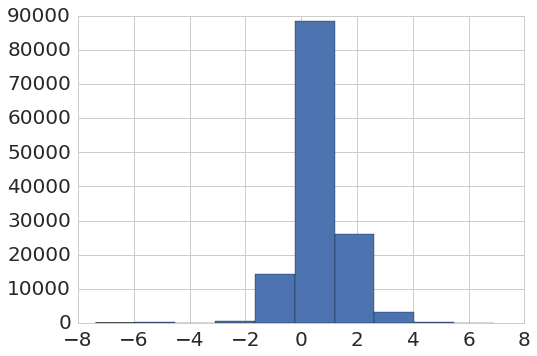

In [44]:
intogen_unique['ddg_pred'].hist()

In [45]:
CORE_OR_INTERFACE

1

In [46]:
sp.stats.pearsonr(
    intogen_unique['cadd_phred'].values,
    intogen_unique['provean_score'].values)

(-0.56185945831078643, 0.0)

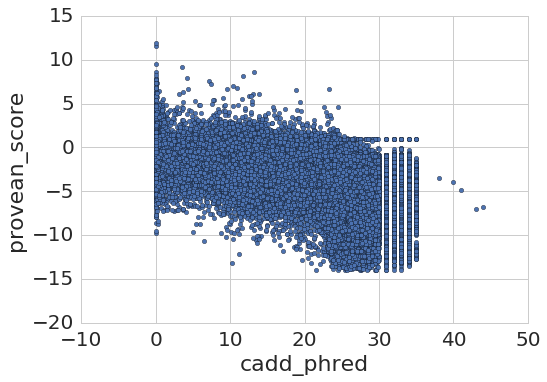

In [28]:
intogen_unique.plot(x='cadd_phred', y='provean_score', kind='scatter')

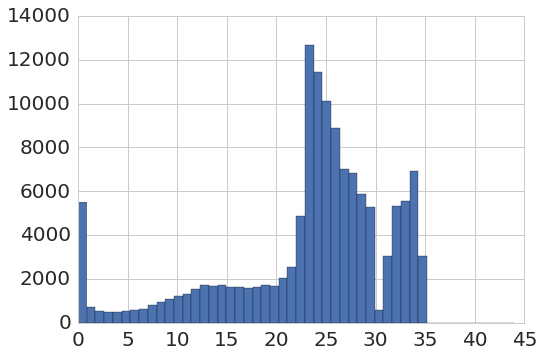

In [29]:
intogen_unique['cadd_phred'].hist(bins=50)

In [77]:
Counter(intogen_unique['cancer'])

Counter({'ALL': 16,
         'AML': 66,
         'BLCA': 488,
         'BRCA': 957,
         'CLL': 123,
         'CM': 1831,
         'COREAD': 431,
         'DLBCL': 47,
         'ESCA': 412,
         'GBM': 421,
         'HC': 110,
         'HNSC': 337,
         'LGG': 119,
         'LUAD': 1003,
         'LUSC': 965,
         'MB': 57,
         'MM': 27,
         'NB': 109,
         'NSCLC': 16,
         'OV': 403,
         'PAAD': 90,
         'PIA': 5,
         'PRAD': 176,
         'RCCC': 467,
         'SCLC': 326,
         'STAD': 654,
         'THCA': 86,
         'UCEC': 907})

In [78]:
Counter(intogen_unique['known_predisposing'].dropna())

Counter({'CANCER-PR': 110, 'CM-PR': 1, 'DT-PR': 2})

In [79]:
Counter(intogen_unique.drop_duplicates(subset=['uniprot_id'])['driver_gene'].dropna())

Counter({'other_tumor_driver': 212, 'tumor_driver': 121})

In [80]:
Counter(intogen_unique.drop_duplicates(subset=['uniprot_id'])['gene_role'].dropna())

Counter({'Act': 226, 'LoF': 278, 'ambiguous': 76})

In [81]:
Counter(intogen_unique.drop_duplicates(subset=['uniprot_id'])['driver_mut_prediction'].dropna())

Counter({'TIER 1': 147, 'TIER 2': 76, 'passenger': 3213})

In [82]:
Counter(intogen_unique['alt_type'].dropna())

Counter({'MUT': 10649})

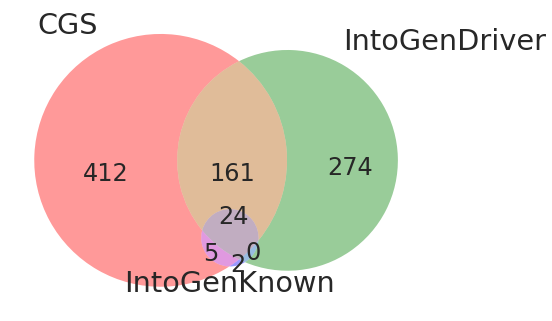

In [84]:
matplotlib_venn.venn3(
    [set(cancer_gene_census.gene_symbol), 
     set(intogen_cancer_drivers.gene_name), 
     set(intogen_unique[intogen_unique['driver'] == 'known'].gene)],
    ['CGS', 'IntoGenDriver', 'IntoGenKnown']
)

In [80]:
COSMIC.shape

(357703, 140)

In [81]:
COSMIC.drop_duplicates(subset=['uniprot_id', 'uniprot_mutation']).shape

(357703, 140)

In [86]:
Counter(intogen_cancer_drivers['role'])

Counter({'Activating': 169, 'Loss of function': 207, 'No class': 83})

In [81]:
cancer_gene_census['in_cgs'] = True

In [401]:
df = (
#     intogen_unique
    COSMIC
    [
     (COSMIC['del_class_exp'] == 1)  
     & (~COSMIC['uniprot_id'].isin(train_uniprot_ids))
     & (~COSMIC['gene_name'].isin(train_gene_names))
    ]
    .groupby(['gene_name', 'uniprot_mutation'], as_index=False).mean()
    .merge(
        cancer_gene_census[['gene_symbol', 'molecular_genetics', 'role_in_cancer', 'in_cgs']], 
#         left_on=['gene'],
        left_on=['gene_name'], 
        right_on=['gene_symbol'], 
        how='left')
#     .merge(intogen_cancer_drivers[['gene_name', 'role']], left_on=['gene'], right_on=['gene_name'])
)

In [104]:
docm_variants['in_docm'] = True

In [283]:
Counter(cancer_gene_census['molecular_genetics'])

Counter({nan: 7, 'Dom/Rec': 7, 'Rec/X': 3, 'Dom': 448, 'Rec': 137})

In [237]:
Counter(cancer_gene_census['role_in_cancer'])

Counter({nan: 365, 'TSG': 90, 'oncogene': 114, 'oncogene/TSG': 33})

In [402]:
df['gene_role'] = ''
df.loc[df['molecular_genetics'] == 'Dom', 'gene_role'] = 'Act'
df.loc[df['molecular_genetics'] == 'Rec', 'gene_role'] = 'LoF'
# Take out other genes in CGS
df.loc[(df['gene_role'] == '') & (df['in_cgs'] == True), 'gene_role'] = 'NA'

In [406]:
_before = df.shape[0]
df = df.merge(
    docm_variants[['gene', 'ensembl_mutation', 'in_docm']]
    .groupby(['gene', 'ensembl_mutation'], as_index=False).mean(),
    left_on=['gene_name', 'uniprot_mutation'],
#     left_on=['gene', 'uniprot_mutation'],
    right_on=['gene', 'ensembl_mutation'],
    how='left'
)
assert df.shape[0] == _before
df.loc[(df['gene_role'] != '') & (df['in_docm'] != True), 'gene_role'] = 'NA'

In [387]:
df[df.shape

(277628, 107)

In [128]:
df = (
    df
    [
        (df['driver_gene'] == 'other_tumor_driver')
#         (df['driver_mut_prediction'] == 'TIER 1')
#         (df['driver'] == 'known')
    ]
)

In [108]:
df.shape

(169, 109)

In [189]:
intogen_unique[intogen_unique['driver'] == 'known']['gene'].drop_duplicates().shape

(51,)

In [184]:
df = (
    intogen_unique
    [
#         (intogen_unique['driver_gene'] == 'other_tumor_driver')
#         (intogen_unique['driver_gene'] == 'tumor_driver')
#         (intogen_unique['driver_mut_prediction'] == 'TIER 1')
#         intogen_unique['known_predisposing'].notnull()
#         (intogen_unique['driver'] == 'known')
        & (~intogen_unique['uniprot_id'].isin(train_uniprot_ids))
        & (~intogen_unique['gene'].isin(train_gene_names))
    ]
)

In [145]:
df['ddg_pred'] = df['ddg_pred_interface']

In [207]:
df = df[df['cadd_phred'] > 20]

In [208]:
df.shape

(6029, 114)

In [276]:
# Functions
import sklearn.metrics

def get_roc_values(column):
    lof = df[df['gene_role'] == 'LoF'][column]
    act = df[df['gene_role'] == 'Act'][column]

    y = np.array([1] * len(lof) + [0] * len(act))
    scores = np.hstack([lof, act])

    if column in ['provean_score']:
        scores = -scores
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, scores)
    return fpr, tpr


def get_auc_score(column):
    lof = df[df['gene_role'] == 'LoF'][column]
    act = df[df['gene_role'] == 'Act'][column]

    y = np.array([1] * len(lof) + [0] * len(act))
    scores = np.hstack([lof, act])

    if column in ['provean_score']:
        scores = -scores
    auc = sklearn.metrics.roc_auc_score(y, scores)
    return auc


def make_roc_curve():
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--')
    plt.plot(
        *get_roc_values('dg_change'), 
        label='FoldX (AUC: {:.3f})'.format(get_auc_score('dg_change')),
        linewidth=2,
        color=sns.palettes.color_palette()[0])
    plt.plot(
        *get_roc_values('ddg_pred'), 
        label='ELASPIC (AUC: {:.3f})'.format(get_auc_score('ddg_pred')),
        linewidth=2,
        color=sns.palettes.color_palette()[2])
    plt.plot(
        *get_roc_values('provean_score'), 
        label='Provean (AUC: {:.3f})'.format(get_auc_score('provean_score')),
        linewidth=2,
        color=sns.palettes.color_palette()[4])
    plt.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

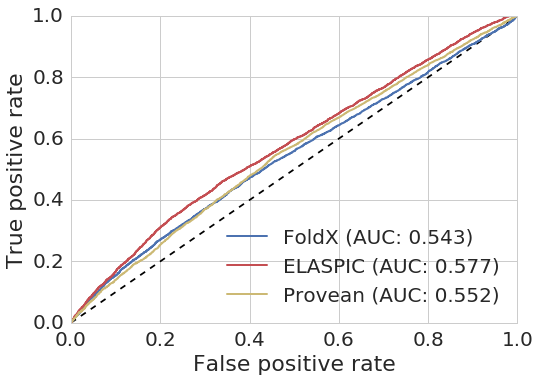

In [277]:
make_roc_curve()
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_full.png'),
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_full.pdf'),
    bbox_inches='tight')

In [278]:
df = df.groupby(['gene_name', 'gene_role'], as_index=False).mean()

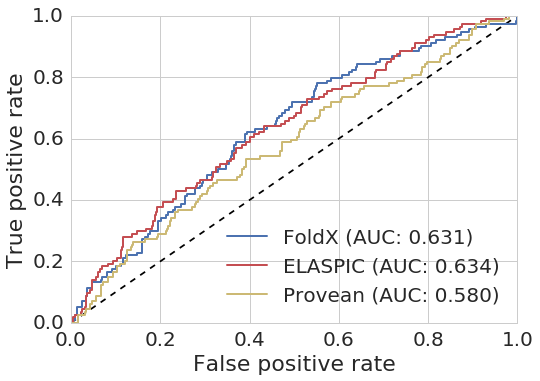

In [279]:
make_roc_curve()
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_bygene_full.png'),
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_bygene_full.pdf'),
    bbox_inches='tight')

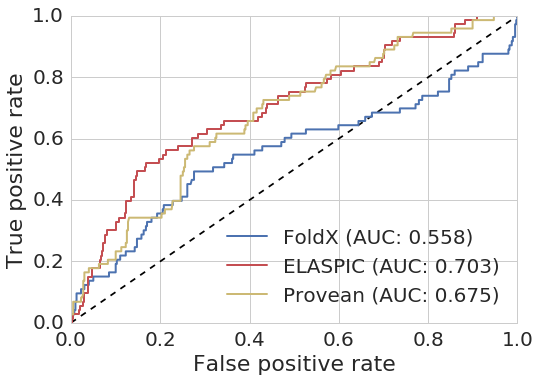

In [283]:
make_roc_curve()
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_high_confidence.png'), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_high_confidence.pdf'),
    bbox_inches='tight')

In [284]:
df = df.groupby(['gene', 'gene_role'], as_index=False).mean()

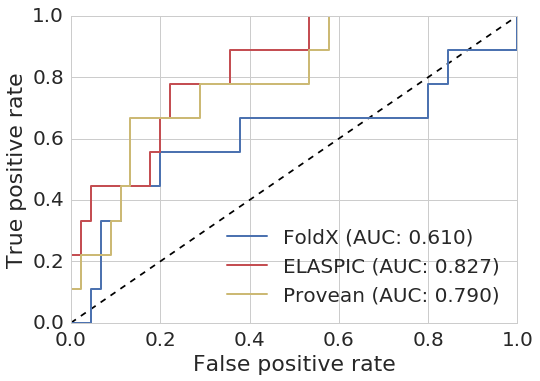

In [285]:
make_roc_curve()
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_bygene_high_confidence.png'),
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'roc_curve_bygene_high_confidence.pdf'),
    bbox_inches='tight')

# Questions

- Average mutation ddG for oncogenes vs tsg?

In [305]:
df = df.groupby(['uniprot_id', 'gene_role'], as_index=False).mean()

In [313]:
df[~df['gene_role'].isin(['Act', 'LoF'])]['ddg_pred'].shape

(126400,)

In [396]:
# Functions
def plot(column, clip, palette_idx=0):
    sns.kdeplot(
        df[df['gene_role'] == ''][column], clip=clip, ax=ax, 
        linewidth=3, label='Passenger (n = {:,.0f})'.format(df[df['gene_role'] == ''].shape[0]),
        color=sns.palettes.color_palette()[1])
    sns.kdeplot(
        df[df['gene_role'] == 'Act'][column], clip=clip, ax=ax, 
        linewidth=3, label='Oncogene (n = {:,.0f})'.format(df[df['gene_role'] == 'Act'].shape[0]),
        color=sns.palettes.color_palette()[3])
    sns.kdeplot(
        df[df['gene_role'] == 'LoF'][column], clip=clip, ax=ax, 
        linewidth=3, label='Tumour suppressor gene (n = {:,.0f})'.format(df[df['gene_role'] == 'LoF'].shape[0]),
        color=sns.palettes.color_palette()[5])
    ax.set_xlim(clip)


/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


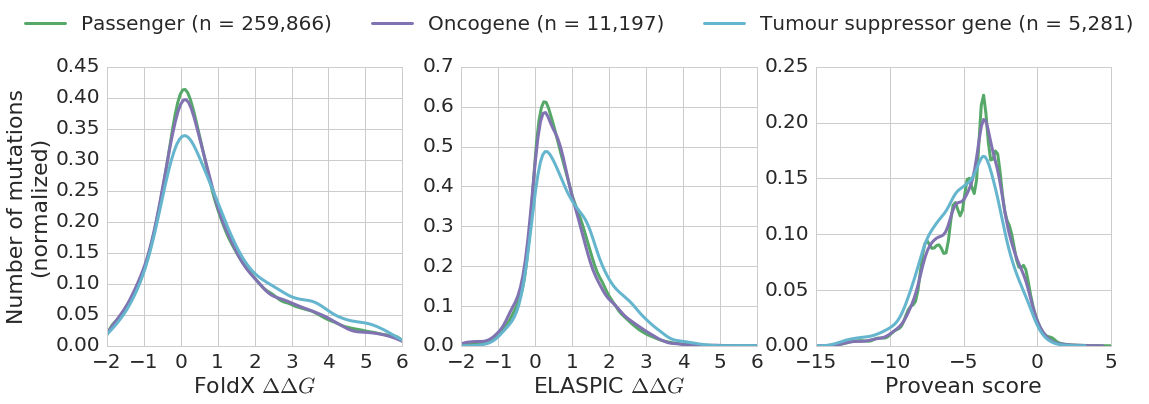

In [398]:
# COSMIC
fg, axes = plt.subplots(1, 3, figsize=(18, 5))

# FoldX
ax = axes[0]
plot('dg_change', (-2, 6), 1)
ax.legend().set_visible(False)
ax.set_xlabel('FoldX $\Delta \Delta G$')
ax.set_ylabel('Number of mutations\n(normalized)')


# ELASPIC
ax = axes[1]
plot('ddg_pred', (-2, 6), 3)
ax.legend(loc='upper center', bbox_to_anchor=(0.4, 1.25), ncol=3)
ax.set_xlabel('ELASPIC $\Delta \Delta G$')


# Provean
ax = axes[2]
plot('provean_score', (-15, 5), 5)
ax.legend().set_visible(False)
ax.set_xlabel('Provean score')


plt.savefig(
    op.join(NOTEBOOK_NAME, 'score_distribution_full.png'),
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'score_distribution_full.pdf'),
    bbox_inches='tight')

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


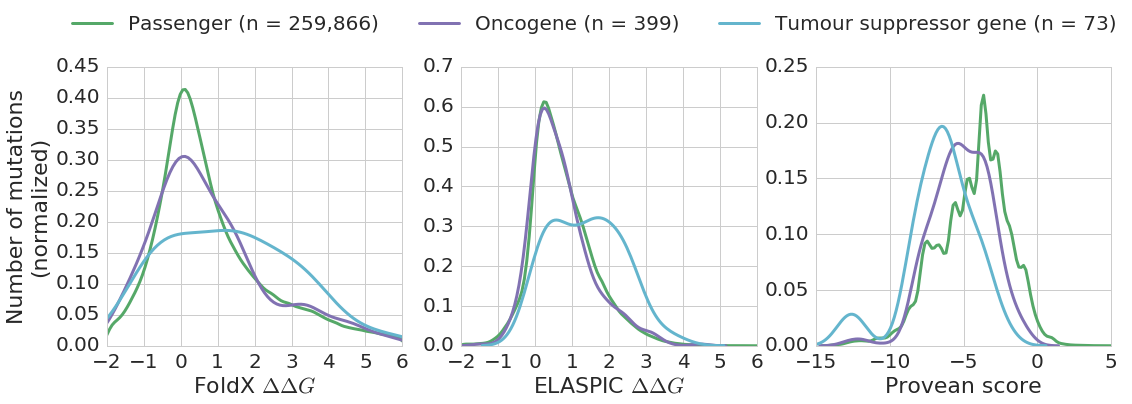

In [400]:
# DOCM
fg, axes = plt.subplots(1, 3, figsize=(18, 5))

# FoldX
ax = axes[0]
plot('dg_change', (-2, 6), 1)
ax.legend().set_visible(False)
ax.set_xlabel('FoldX $\Delta \Delta G$')
ax.set_ylabel('Number of mutations\n(normalized)')


# ELASPIC
ax = axes[1]
plot('ddg_pred', (-2, 6), 3)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.25), ncol=3)
ax.set_xlabel('ELASPIC $\Delta \Delta G$')


# Provean
ax = axes[2]
plot('provean_score', (-15, 5), 5)
ax.legend().set_visible(False)
ax.set_xlabel('Provean score')


plt.savefig(
    op.join(NOTEBOOK_NAME, 'score_distribution_high_confidence.png'),
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'score_distribution_high_confidence.pdf'),
    bbox_inches='tight')

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


RanksumsResult(statistic=-4.7662633268678851, pvalue=1.8767394786328539e-06)
-1.3702954303567152


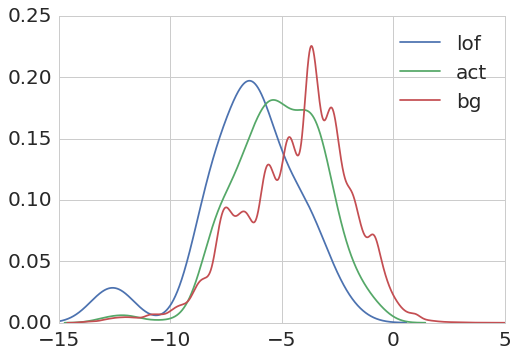

In [407]:
# Provean
clip = (-15, 5)
sns.kdeplot(df[df['gene_role'] == 'LoF']['provean_score'], label='lof', clip=clip, gridsize=10000)
sns.kdeplot(df[df['gene_role'] == 'Act']['provean_score'], label='act', clip=clip, gridsize=10000)
sns.kdeplot(df[df['gene_role'] == '']['provean_score'], label='bg', clip=clip, gridsize=10000)
plt.xlim(clip)

p = sp.stats.ranksums(
    df[df['gene_role'] == 'LoF']['provean_score'].values,
    df[df['gene_role'] == 'Act']['provean_score'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['provean_score'].mean() - df[df['gene_role'] == 'Act']['provean_score'].mean())

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


RanksumsResult(statistic=5.5068213746199248, pvalue=3.6537065288844206e-08)
0.7118691469596581


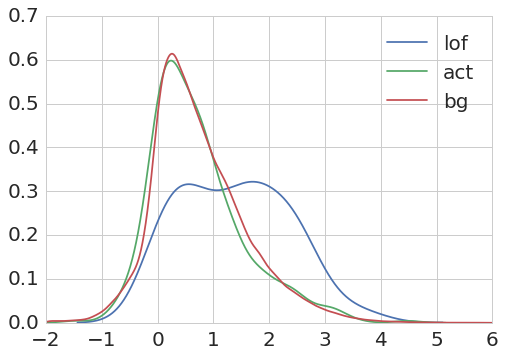

In [408]:
# ELASPIC
sns.kdeplot(df[df['gene_role'] == 'LoF']['ddg_pred'], label='lof', clip=(-2, 6), gridsize=10000)
sns.kdeplot(df[df['gene_role'] == 'Act']['ddg_pred'], label='act', clip=(-2, 6), gridsize=10000)
sns.kdeplot(df[df['gene_role'] == '']['ddg_pred'], label='bg', clip=(-2, 6), gridsize=10000)
plt.xlim(-2, 6)

p = sp.stats.ranksums(
    df[df['gene_role'] == 'LoF']['ddg_pred'].values,
    df[df['gene_role'] == 'Act']['ddg_pred'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['ddg_pred'].mean() - df[df['gene_role'] == 'Act']['ddg_pred'].mean())

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


RanksumsResult(statistic=1.574444141849642, pvalue=0.11538480560310152)
1.0882594293659598


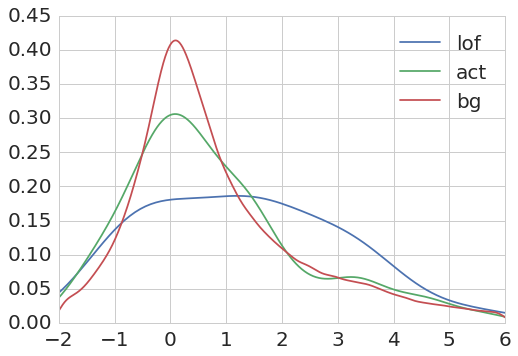

In [409]:
# FoldX
sns.kdeplot(df[df['gene_role'] == 'LoF']['dg_change'], label='lof', clip=(-2, 6))
sns.kdeplot(df[df['gene_role'] == 'Act']['dg_change'], label='act', clip=(-2, 6), gridsize=1000)
sns.kdeplot(df[df['gene_role'] == '']['dg_change'], label='bg', clip=(-2, 6), gridsize=1000)
plt.xlim(-2, 6)

p = sp.stats.ranksums(
    df[df['gene_role'] == 'LoF']['dg_change'].values,
    df[df['gene_role'] == 'Act']['dg_change'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['dg_change'].mean() - df[df['gene_role'] == 'Act']['dg_change'].mean())

# Interface mutations

In [581]:
sql_query = """\
SELECT count(*) 
FROM mutation_sets.humsavar
WHERE del_class_exp = 0
AND uniprot_id IN (SELECT uniprot_id FROM mutation_sets.humsavar WHERE del_class_exp = 1);
"""

In [582]:
A = pd.read_sql_query(sql_query, db_remote.engine)
A

,count(*)
0,8559


In [583]:
sql_query = """\
SELECT count(*) 
FROM mutation_sets.humsavar
WHERE (uniprot_id, uniprot_mutation) IN (
    SELECT uniprot_id, mutation 
    FROM elaspic.uniprot_domain_pair_mutation 
    WHERE ddg IS NOT NULL)
AND del_class_exp = 0 
AND uniprot_id IN (SELECT uniprot_id FROM mutation_sets.humsavar WHERE del_class_exp = 1);
"""

In [584]:
B = pd.read_sql_query(sql_query, db_remote.engine)
B

,count(*)
0,367


In [585]:
B / A

,count(*)
0,0.042879


In [457]:
# 3.5 / # 8.4

In [534]:
sql_query = """\
SELECT uniprot_id, uniprot_mutation, num_interactions, ddg
FROM mutation_sets.humsavar
JOIN (SELECT *, mutation uniprot_mutation FROM elaspic.uniprot_domain_pair_mutation) t 
    USING (uniprot_id, uniprot_mutation)
JOIN elaspic.uniprot_domain_pair USING (uniprot_domain_pair_id)
JOIN mutation_sets.elaspic_num_interactions USING (uniprot_id)
WHERE num_interactions > 1 AND del_class_exp = 1
AND (uniprot_id_1 not like '%%-%%' and uniprot_id_2 not like '%%-%%')
AND (
    (uniprot_id_1 = uniprot_id AND 
     uniprot_id_2 IN (SELECT uniprot_id from uniprot_kb.uniprot_sequence WHERE db = 'sp'))
    OR
    (uniprot_id_2 = uniprot_id AND
     uniprot_id_1 IN (SELECT uniprot_id from uniprot_kb.uniprot_sequence WHERE db = 'sp'))
)
"""

In [533]:
A = pd.read_sql_query(sql_query, db_remote.engine)

In [541]:
B = pd.read_sql_query(sql_query, db_remote.engine)

array([ 2.43147   ,  1.74382667,  0.302952  , ...,  2.00791   ,
        2.32856   ,  0.6679185 ])

In [549]:
sp.stats.ranksums(
    A.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].agg(lambda x: np.mean(x)).values,
    B.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].agg(lambda x: np.mean(x)).values)

RanksumsResult(statistic=-19.502665259980603, pvalue=1.042078349490217e-84)

In [572]:
(A.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count() == 1).sum() / \
(A.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count()).shape[0]

0.63566552901023887

In [573]:
(B.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count() == 1).sum() / \
(B.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count()).shape[0]

0.5580357142857143

In [558]:
(A.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count() == 1).sum()

745

In [570]:
(A.groupby(['uniprot_id', 'uniprot_mutation'])['ddg'].count() == 1).sum()

745

In [578]:
5 / 1167 

0.004284490145672665

In [577]:
gp = A.groupby(['uniprot_id', 'uniprot_mutation'])
(gp['ddg'].count() / gp['num_interactions'].agg(lambda x: x.values[0]) != 1).sum()

1167

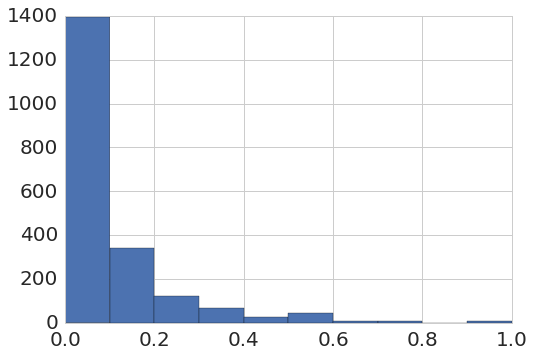

In [529]:
gp = A.groupby(['uniprot_id', 'uniprot_mutation'])
(gp['ddg'].count() / gp['num_interactions'].agg(lambda x: x.values[0])).hist(range=(0, 1))

In [ ]:
sql_query = """\
SELECT count(*) 
FROM mutation_sets.humsavar
WHERE (uniprot_id, uniprot_mutation) IN (
    SELECT uniprot_id, mutation 
    FROM elaspic.uniprot_domain_pair_mutation 
    WHERE ddg IS NOT NULL)
AND del_class_exp = 1;
"""

In [ ]:
B = pd.read_sql_query(sql_query, db_remote.engine)
B

In [ ]:
B / A

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


RanksumsResult(statistic=7.9921704324367484, pvalue=1.3258357352250978e-15)
-1.4859081545975767


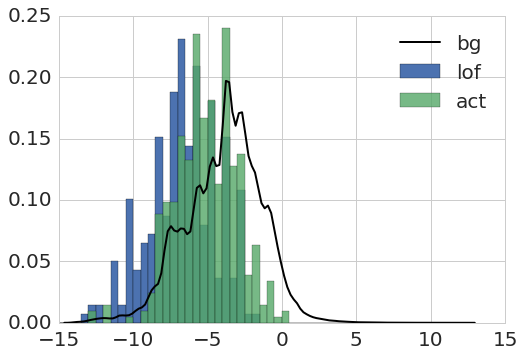

In [196]:
# Provean
plt.hist(
    df[df['gene_role'] == 'LoF']['provean_score'], 
#     histtype='step', linewidth=2, 
    normed=True, label='lof', bins=40, range=(-15, 5))
plt.hist(
    df[df['gene_role'] == 'Act']['provean_score'], 
#     histtype='step', linewidth=2, 
    alpha=0.8,
    normed=True, label='act', bins=40, range=(-15, 5))
sns.kdeplot(df[df['gene_role'] == '']['provean_score'], label='bg', color='k', linewidth=2)
# plt.hist(
#     df[df['gene_role'] == '']['provean_score'], 
#     histtype='step', linewidth=2, normed=True, label='bg', bins=40, range=(-15, 5))
plt.legend()

p = sp.stats.ranksums(
    -df[df['gene_role'] == 'LoF']['provean_score'].values,
    -df[df['gene_role'] == 'Act']['provean_score'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['provean_score'].mean() - df[df['gene_role'] == 'Act']['provean_score'].mean())

RanksumsResult(statistic=14.632149583951735, pvalue=1.7516423911817777e-48)
1.227596666935311


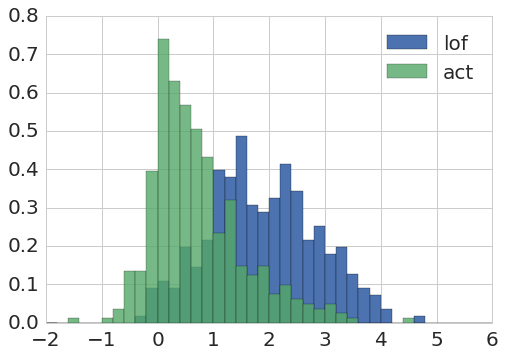

In [222]:
# ELASPIC
plt.hist(
    df[df['gene_role'] == 'LoF']['ddg_pred'], 
#     histtype='step', linewidth=2, 
    normed=True, alpha=1, bins=40, label='lof', range=(-2, 6))
plt.hist(
    df[df['gene_role'] == 'Act']['ddg_pred'], 
#     histtype='step', linewidth=2, 
    normed=True, alpha=0.8, bins=40, label='act', range=(-2, 6))
# plt.hist(
#     df[df['gene_role'] == '']['ddg_pred'], 
# #     histtype='step', linewidth=2, 
#     normed=True, alpha=0.5, bins=40, label='bg', range=(-2, 6))
plt.legend()

p = sp.stats.ranksums(
    df[df['gene_role'] == 'LoF']['ddg_pred'].values,
    df[df['gene_role'] == 'Act']['ddg_pred'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['ddg_pred'].mean() - df[df['gene_role'] == 'Act']['ddg_pred'].mean())

RanksumsResult(statistic=8.0797068188217036, pvalue=6.492266709719508e-16)
2.66778981126566


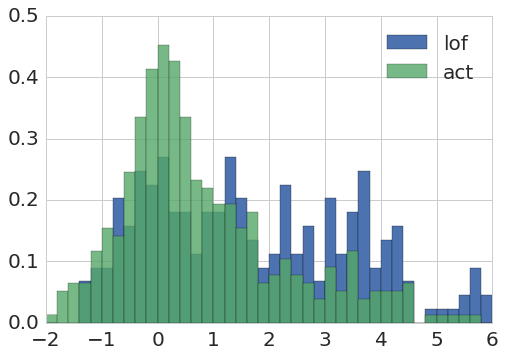

In [198]:
# FoldX
plt.hist(df[df['gene_role'] == 'LoF']['dg_change'], normed=True, bins=40, label='lof', range=(-2, 6))
plt.hist(df[df['gene_role'] == 'Act']['dg_change'], normed=True, alpha=0.8, bins=40, label='act', range=(-2, 6))
plt.legend()

p = sp.stats.ranksums(
    df[df['gene_role'] == 'LoF']['dg_change'].values,
    df[df['gene_role'] == 'Act']['dg_change'].values
)
print(p)

print(df[df['gene_role'] == 'LoF']['dg_change'].mean() - df[df['gene_role'] == 'Act']['dg_change'].mean())

RanksumsResult(statistic=-14.796467777639746, pvalue=1.5437952457826978e-49)
0.7020413804146642


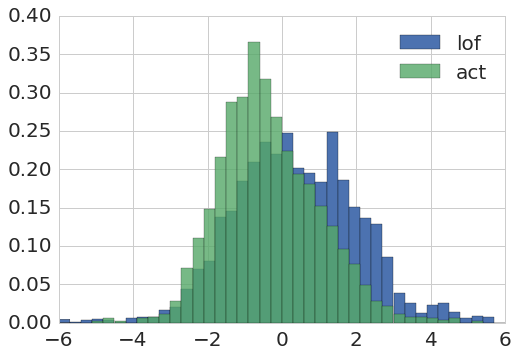

In [163]:
# ELASPIC - Provean
ddg_act_standard = (
    (df[df['gene_role'] == 'Act']['ddg_pred'] - 
     df['ddg_pred'].mean()) / 
    (df['ddg_pred'].std())
)
ddg_lof_standard = (
    (df[df['gene_role'] == 'LoF']['ddg_pred'] - 
     df['ddg_pred'].mean()) / 
    (df['ddg_pred'].std())
)


provean_act_standard = (
    (df[df['gene_role'] == 'Act']['provean_score'] - 
     df['provean_score'].mean()) / 
    (df['provean_score'].std())
)
provean_lof_standard = (
    (df[df['gene_role'] == 'LoF']['provean_score'] - 
     df['provean_score'].mean()) / 
    (df['provean_score'].std())
)


result_act = ddg_act_standard - provean_act_standard
result_lof = ddg_lof_standard - provean_lof_standard


plt.hist(result_lof, normed=True, bins=40, label='lof', range=(-6, 6))
plt.hist(result_act, normed=True, bins=40, label='act', range=(-6, 6), alpha=0.8)
plt.legend()

p = sp.stats.ranksums(result_act.values, result_lof.values)
print(p)

print(result_lof.mean() - result_act.mean())

RanksumsResult(statistic=-8.9928871741217513, pvalue=2.4081941908744981e-19)

RanksumsResult(statistic=-4.1741178818952216, pvalue=2.9914284388064938e-05)

RanksumsResult(statistic=-8.4879102360288936, pvalue=2.1038597060057514e-17)

In [26]:
sp.stats.ranksums([1, 2, 3], [2,3,4, 4, 5])

RanksumsResult(statistic=-1.6397831834998458, pvalue=0.10105025592540992)

In [27]:
sp.stats.ranksums([1, 2, 3], [200000,300000,40000, 400, 500])

RanksumsResult(statistic=-2.2360679774997898, pvalue=0.025347318677468252)

In [28]:
df[[
    'uniprot_id',
    'uniprot_mutation',
    'known_oncogenic',
    'known_predisposing',
    'driver_gene',
    'gene_role',
    'cancer',
    'alt_type',
    'driver',
]].describe(include=[object])

,uniprot_id,uniprot_mutation,known_oncogenic,known_predisposing,driver_gene,gene_role,cancer,alt_type,driver
count,602956,602956,403264,59920,439298,448993,602956,602956,432272
unique,11856,67239,101,5,2,3,28,1,2
top,P42336,V600E,L;COREAD;OV;B;NSMGCT;COC;MM;THCA;G;GIST;PG;HCL...,CANCER-PR,tumor_driver,Act,CM,MUT,known
freq,132966,130321,130321,59629,425563,363263,113414,602956,412548


In [29]:
for c in df.columns:
    print(c)

gdna
ensembl_id
ensembl_mutation
known_oncogenic
known_predisposing
driver_gene
gene_role
driver_mut_prediction
cancer
alt_type
driver
uniprot_domain_id
template_errors
cath_id
domain_start
domain_end
domain_def
alignment_identity
alignment_coverage
alignment_score
t_date_modified
model_errors
alignment_filename
model_filename
chain
norm_dope
sasa_score
m_date_modified
model_domain_def
uniprot_id
mutation
mutation_errors
model_filename_wt
model_filename_mut
chain_modeller
mutation_modeller
matrix_score
secondary_structure_wt
solvent_accessibility_wt
secondary_structure_change
solvent_accessibility_change
provean_score
ddg
mut_date_modified
uniprot_mutation
pcv_salt_equal_wt
pcv_salt_equal_self_wt
pcv_salt_equal_change
pcv_salt_equal_self_change
pcv_salt_opposite_wt
pcv_salt_opposite_self_wt
pcv_salt_opposite_change
pcv_salt_opposite_self_change
pcv_hbond_wt
pcv_hbond_self_wt
pcv_hbond_change
pcv_hbond_self_change
pcv_vdw_wt
pcv_vdw_self_wt
pcv_vdw_change
pcv_vdw_self_change
dg_wt
backb